mlflow ui --backend-store-uri sqlite:///mlflow.db

In [1]:
!python -V

Python 3.13.2


In [2]:
import pandas as pd

In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [6]:
import mlflow

mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("my2_scnd_experiment")


2025/05/21 11:30:07 INFO mlflow.tracking.fluent: Experiment with name 'my2_scnd_experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1747819807324, experiment_id='1', last_update_time=1747819807324, lifecycle_stage='active', name='my2_scnd_experiment', tags={}>

In [7]:
print("Tracking URI:", mlflow.get_tracking_uri())


Tracking URI: http://127.0.0.1:5000


In [8]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')

In [9]:
df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)

In [10]:
df['duration'] =df.lpep_dropoff_datetime - df.lpep_pickup_datetime

In [11]:
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60) #convert to minutes

In [12]:
df=df[df.trip_type == 2] #Dispatch

In [13]:
df.duration.describe(percentiles=[0.95,0.98,0.99])

count    1238.000000
mean       18.305493
std       108.364382
min         0.000000
50%         1.666667
95%        35.604167
98%        59.339333
99%       149.837833
max      1416.100000
Name: duration, dtype: float64

In [14]:
((df.duration >= 1) & (df.duration <= 60)).mean()

np.float64(0.5169628432956381)

In [15]:
df = df[((df.duration >= 1) & (df.duration <= 60))]

In [16]:
categorical = ['PULocationID','DOLocationID']
numerical = ['trip_distance']

In [17]:
df[categorical] = df[categorical].astype(str)

In [18]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
30,2,2021-01-01 00:35:29,2021-01-01 00:55:15,N,5.0,74,247,1.0,3.64,13.0,...,0.0,0.0,0.0,None,0.3,13.3,2.0,2.0,0.0,19.766667
53,2,2021-01-01 01:54:51,2021-01-01 02:15:35,N,5.0,74,94,1.0,5.82,18.0,...,0.0,0.0,0.0,None,0.3,18.3,2.0,2.0,0.0,20.733333
69,2,2021-01-01 02:42:49,2021-01-01 02:50:59,N,5.0,136,241,1.0,0.57,9.0,...,0.0,0.0,0.0,None,0.3,9.3,2.0,2.0,0.0,8.166667
88,2,2021-01-01 04:52:02,2021-01-01 05:05:01,N,5.0,247,75,1.0,3.43,15.0,...,0.0,0.0,0.0,None,0.3,15.3,2.0,2.0,0.0,12.983333
96,2,2021-01-01 05:52:43,2021-01-01 05:58:02,N,5.0,7,7,1.0,0.65,50.0,...,0.0,7.0,0.0,None,0.3,57.3,1.0,2.0,0.0,5.316667


In [19]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

In [20]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [21]:
X_train

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1920 stored elements and shape (640, 236)>

In [22]:
dv.feature_names_

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=106',
 'DOLocationID=107',
 'DOLocationID=112',
 'DOLocationID=116',
 'DOLocationID=118',
 'DOLocationID=119',
 'DOLocationID=121',
 'DOLocationID=126',
 'DOLocationID=127',
 'DOLocationID=128',
 'DOLocationID=129',
 'DOLocationID=130',
 'DOLocationID=131',
 'DOLocationID=132',
 'DOLocationID=134',
 'DOLocationID=135',
 'DOLocationID=136',
 'DOLocationID=138',
 'DOLocationID=140',
 'DOLocationID=141',
 'DOLocationID=143',
 'DOLocationID=145',
 'DOLocationID=146',
 'DOLocationID=147',
 'DOLocationID=148',
 'DOLocationID=151',
 'DOLocationID=152',
 'DOLocationID=156',
 'DOLocationID=159',
 'DOLocationID=16',
 'DOLocationID=161',
 'DOLocationID=162',
 'DOLocationID=163',
 'DOLocationID=165',
 'DOLocationID=166',
 'DOLocationID=167',
 'DOLocationID=168',
 'DOLocationID=169',
 'DOLocationID=17',
 'DOLocationID=170',
 'DOLocationID=173',
 'DOLocationID=174',
 'DOLocationID=177',
 'DOLocationID=179',
 'DOLocationID=18',
 'DOLocationID=182'

In [23]:
target = 'duration'
y_train = df[target].values

In [24]:
y_train

array([19.76666667, 20.73333333,  8.16666667, 12.98333333,  5.31666667,
        1.26666667,  1.6       ,  5.03333333,  1.86666667,  6.38333333,
       34.71666667,  1.35      , 27.23333333,  9.11666667, 26.23333333,
       28.75      , 22.01666667, 21.85      , 20.96666667, 21.61666667,
        9.26666667, 22.63333333, 25.41666667,  1.2       , 16.7       ,
       49.2       ,  7.35      , 14.16666667, 13.58333333, 24.06666667,
       24.2       , 27.21666667, 19.61666667, 12.71666667, 18.83333333,
        6.26666667,  2.53333333, 13.26666667,  7.63333333, 54.71666667,
        3.75      ,  4.15      ,  3.65      , 10.26666667,  5.6       ,
        2.93333333, 33.95      ,  6.53333333, 10.08333333, 21.96666667,
       30.96666667,  5.78333333, 11.05      ,  7.35      , 18.15      ,
       10.25      ,  1.95      ,  1.95      , 38.2       , 12.3       ,
       14.03333333, 16.91666667,  3.83333333, 14.31666667,  7.01666667,
       19.56666667,  6.41666667, 38.48333333, 34.98333333, 10.38

In [25]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [26]:
y_pred = lr.predict(X_train)

C:\Users\Christian\AppData\Local\Temp\ipykernel_31472\3882591490.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
C:\Users\Christian\AppData\Local\Temp\ipykernel_31472\3882591490.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train,label='actual')


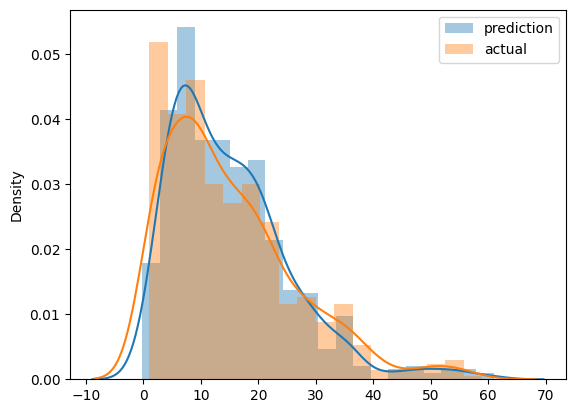

In [27]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train,label='actual')
plt.legend()

In [28]:
import math
rmse = mean_squared_error(y_train, y_pred)
math.sqrt(rmse)

4.803126149499836

In [29]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    
    df['duration'] =df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds()  / 60)
    
    df = df[((df.duration >= 1) & (df.duration <= 60))]
    
    categorical = ['PULocationID','DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [30]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')

In [31]:
len(df_train), len(df_val)

(73908, 61921)

In [32]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [33]:
df_val

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration,PU_DO
0,2,2021-02-01 00:34:03,2021-02-01 00:51:58,N,1.0,130,205,5.0,3.66,14.00,...,10.00,0.0,None,0.3,25.30,1.0,1.0,0.00,17.916667,130_205
1,2,2021-02-01 00:04:00,2021-02-01 00:10:30,N,1.0,152,244,1.0,1.10,6.50,...,0.00,0.0,None,0.3,7.80,2.0,1.0,0.00,6.500000,152_244
2,2,2021-02-01 00:18:51,2021-02-01 00:34:06,N,1.0,152,48,1.0,4.93,16.50,...,0.00,0.0,None,0.3,20.55,2.0,1.0,2.75,15.250000,152_48
3,2,2021-02-01 00:53:27,2021-02-01 01:11:41,N,1.0,152,241,1.0,6.70,21.00,...,0.00,0.0,None,0.3,22.30,2.0,1.0,0.00,18.233333,152_241
4,2,2021-02-01 00:57:46,2021-02-01 01:06:44,N,1.0,75,42,1.0,1.89,8.50,...,2.45,0.0,None,0.3,12.25,1.0,1.0,0.00,8.966667,75_42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64567,2,2021-02-28 22:19:00,2021-02-28 22:29:00,None,NaN,129,7,NaN,2.63,10.04,...,0.00,0.0,None,0.3,10.34,NaN,NaN,NaN,10.000000,129_7
64568,2,2021-02-28 23:18:00,2021-02-28 23:27:00,None,NaN,116,166,NaN,1.87,8.33,...,1.89,0.0,None,0.3,10.52,NaN,NaN,NaN,9.000000,116_166
64569,2,2021-02-28 23:44:00,2021-02-28 23:58:00,None,NaN,74,151,NaN,2.40,12.61,...,0.00,0.0,None,0.3,12.91,NaN,NaN,NaN,14.000000,74_151
64570,2,2021-02-28 23:07:00,2021-02-28 23:14:00,None,NaN,42,42,NaN,1.11,11.95,...,0.00,0.0,None,0.3,15.00,NaN,NaN,NaN,7.000000,42_42


In [34]:
categorical = ['PU_DO']#'PULocationID','DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)


In [35]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [36]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)

rmse = mean_squared_error(y_val,y_pred)
math.sqrt(rmse)

7.758715202840848

In [37]:
with mlflow.start_run():
    mlflow.set_tag("developer","christian")
    mlflow.log_param("train-data-path","./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path","./data/green_tripdata_2021-02.parquet")
    alpha = 0.001
    mlflow.log_param("alpha",alpha)
    lr = Lasso(alpha)   
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val,y_pred)
    math.sqrt(rmse)
    mlflow.log_metric("rmse",math.sqrt(rmse))

🏃 View run brawny-calf-553 at: http://127.0.0.1:5000/#/experiments/1/runs/e1237b81ba9240b9926e00bb6ae78012
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [38]:
with mlflow.start_run():
    mlflow.set_tag("developer","christian")
    mlflow.log_param("train-data-path","./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path","./data/green_tripdata_2021-02.parquet")
    alpha = 0.1
    mlflow.log_param("alpha",alpha)
    lr = Lasso(alpha)   
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val,y_pred)
    math.sqrt(rmse)
    mlflow.log_metric("rmse",math.sqrt(rmse))

🏃 View run whimsical-hound-919 at: http://127.0.0.1:5000/#/experiments/1/runs/cd58fcad77184e2a90dd864510a14a7a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [39]:
!pip install xgboost

In [40]:
!pip install hyperopt

In [41]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope


In [42]:
train = xgb.DMatrix(X_train,label=y_train)
valid = xgb.DMatrix(X_val,label=y_val)

In [43]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model","xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid,"validation")],
            early_stopping_rounds = 50
        )
        y_pred = booster.predict(valid)
        rmse = math.sqrt(mean_squared_error(y_val,y_pred))
        mlflow.log_metric("rmse",rmse)
    return {'loss': rmse, 'status': STATUS_OK}

In [44]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth',4,100,1)),
    'learning_rate': hp.loguniform('learning_rate',-3,0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight',-1,3),
    'objective': 'reg:linear',
    'seed': 42
}
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [11:30:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.73672                          
[1]	validation-rmse:11.29639                          
[2]	validation-rmse:10.88998                          
[3]	validation-rmse:10.51549                          
[4]	validation-rmse:10.17046                          
[5]	validation-rmse:9.85334                           
[6]	validation-rmse:9.56236                           
[7]	validation-rmse:9.29543                           
[8]	validation-rmse:9.05067                           
[9]	validation-rmse:8.82698                           
[10]	validation-rmse:8.62283                          
[11]	validation-rmse:8.43670                          
[12]	validation-rmse:8.26660                          
[13]	validation-rmse:8.11163                          
[14]	validation-rmse:7.97024                          
[15]	validation-rmse:7.84274                          
[16]	validation-rmse:7.72542                          
[17]	validation-rmse:7.62051                          
[18]	valid

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [11:32:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:9.88552                                                      
[1]	validation-rmse:8.49365                                                      
[2]	validation-rmse:7.69466                                                      
[3]	validation-rmse:7.24980                                                      
[4]	validation-rmse:6.99911                                                      
[5]	validation-rmse:6.85462                                                      
[6]	validation-rmse:6.76891                                                      
[7]	validation-rmse:6.71860                                                      
[8]	validation-rmse:6.68363                                                      
[9]	validation-rmse:6.66073                                                      
[10]	validation-rmse:6.64449                                                     
[11]	validation-rmse:6.63270                                                     
[12]	validation-

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [11:32:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.34618                                                    
[1]	validation-rmse:7.18982                                                    
[2]	validation-rmse:6.85440                                                    
[3]	validation-rmse:6.76338                                                    
[4]	validation-rmse:6.71454                                                    
[5]	validation-rmse:6.69904                                                    
[6]	validation-rmse:6.68584                                                    
[7]	validation-rmse:6.68227                                                    
[8]	validation-rmse:6.67887                                                    
[9]	validation-rmse:6.67136                                                    
[10]	validation-rmse:6.66886                                                   
[11]	validation-rmse:6.66642                                                   
[12]	validation-rmse:6.66081            

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [11:32:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.08288                                                    
[1]	validation-rmse:6.93730                                                    
[2]	validation-rmse:6.63130                                                    
[3]	validation-rmse:6.53604                                                    
[4]	validation-rmse:6.49530                                                    
[5]	validation-rmse:6.47212                                                    
[6]	validation-rmse:6.45848                                                    
[7]	validation-rmse:6.44961                                                    
[8]	validation-rmse:6.44445                                                    
[9]	validation-rmse:6.43694                                                    
[10]	validation-rmse:6.43319                                                   
[11]	validation-rmse:6.42836                                                   
[12]	validation-rmse:6.42417            

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [11:33:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.06316                                                    
[1]	validation-rmse:6.93329                                                    
[2]	validation-rmse:6.64190                                                    
[3]	validation-rmse:6.54560                                                    
[4]	validation-rmse:6.51080                                                    
[5]	validation-rmse:6.48738                                                    
[6]	validation-rmse:6.47482                                                    
[7]	validation-rmse:6.46776                                                    
[8]	validation-rmse:6.46116                                                    
[9]	validation-rmse:6.45659                                                    
[10]	validation-rmse:6.44925                                                   
[11]	validation-rmse:6.44503                                                   
[12]	validation-rmse:6.44031            

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [11:33:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.35291                                                    
[1]	validation-rmse:7.15889                                                    
[2]	validation-rmse:6.80367                                                    
[3]	validation-rmse:6.68295                                                    
[4]	validation-rmse:6.62885                                                    
[5]	validation-rmse:6.60326                                                    
[6]	validation-rmse:6.59120                                                    
[7]	validation-rmse:6.58522                                                    
[8]	validation-rmse:6.57983                                                    
[9]	validation-rmse:6.57754                                                    
[10]	validation-rmse:6.57204                                                   
[11]	validation-rmse:6.56738                                                   
[12]	validation-rmse:6.56342            

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [11:38:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.47692                                                      
[1]	validation-rmse:9.25573                                                       
[2]	validation-rmse:8.41562                                                       
[3]	validation-rmse:7.84999                                                       
[4]	validation-rmse:7.47168                                                       
[5]	validation-rmse:7.22045                                                       
[6]	validation-rmse:7.05471                                                       
[7]	validation-rmse:6.94473                                                       
[8]	validation-rmse:6.86666                                                       
[9]	validation-rmse:6.81227                                                       
[10]	validation-rmse:6.77339                                                      
[11]	validation-rmse:6.74562                                                      
[12]

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [11:39:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.73924                                                      
[1]	validation-rmse:11.30056                                                      
[2]	validation-rmse:10.89578                                                      
[3]	validation-rmse:10.52216                                                      
[4]	validation-rmse:10.17717                                                      
[5]	validation-rmse:9.86011                                                       
[6]	validation-rmse:9.56884                                                       
[7]	validation-rmse:9.30201                                                       
[8]	validation-rmse:9.05487                                                       
[9]	validation-rmse:8.82987                                                       
[10]	validation-rmse:8.62402                                                      
[11]	validation-rmse:8.43605                                                      
[12]

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [11:40:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.29724                                                     
[1]	validation-rmse:8.98594                                                      
[2]	validation-rmse:8.11448                                                      
[3]	validation-rmse:7.54560                                                      
[4]	validation-rmse:7.18186                                                      
[5]	validation-rmse:6.94835                                                      
[6]	validation-rmse:6.79650                                                      
[7]	validation-rmse:6.69459                                                      
[8]	validation-rmse:6.62746                                                      
[9]	validation-rmse:6.58109                                                      
[10]	validation-rmse:6.54728                                                     
[11]	validation-rmse:6.52049                                                     
[12]	validation-

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [11:41:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.13924                                                   
[1]	validation-rmse:10.24929                                                   
[2]	validation-rmse:9.51602                                                    
[3]	validation-rmse:8.91764                                                    
[4]	validation-rmse:8.43227                                                    
[5]	validation-rmse:8.03900                                                    
[6]	validation-rmse:7.72431                                                    
[7]	validation-rmse:7.47289                                                    
[8]	validation-rmse:7.27290                                                    
[9]	validation-rmse:7.11457                                                    
[10]	validation-rmse:6.98844                                                   
[11]	validation-rmse:6.88626                                                   
[12]	validation-rmse:6.80587            

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [11:55:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:10.54774                                                       
[2]	validation-rmse:9.89906                                                        
[3]	validation-rmse:9.35413                                                        
[4]	validation-rmse:8.89852                                                        
[5]	validation-rmse:8.51795                                                        
[6]	validation-rmse:8.20180                                                        
[7]	validation-rmse:7.94102                                                        
[8]	validation-rmse:7.72614                                                        
[9]	validation-rmse:7.54892                                                        
[10]	validation-rmse:7.40468                                                       
[11]	validation-rmse:7.28600                                                       
[12]	validation-rmse:7.18789                                                

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [11:56:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:7.20281                                                        
[1]	validation-rmse:6.66977                                                        
[2]	validation-rmse:6.56899                                                        
[3]	validation-rmse:6.54227                                                        
[4]	validation-rmse:6.53529                                                        
[5]	validation-rmse:6.52672                                                        
[6]	validation-rmse:6.51733                                                        
[7]	validation-rmse:6.51280                                                        
[8]	validation-rmse:6.50698                                                        
[9]	validation-rmse:6.49578                                                        
[10]	validation-rmse:6.49207                                                       
[11]	validation-rmse:6.48969                                                

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [11:56:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:7.79037                                                        
[1]	validation-rmse:6.95125                                                        
[2]	validation-rmse:6.78075                                                        
[3]	validation-rmse:6.72912                                                        
[4]	validation-rmse:6.71137                                                        
[5]	validation-rmse:6.69871                                                        
[6]	validation-rmse:6.69403                                                        
[7]	validation-rmse:6.68948                                                        
[8]	validation-rmse:6.68645                                                        
[9]	validation-rmse:6.68227                                                        
[10]	validation-rmse:6.68042                                                       
[11]	validation-rmse:6.67954                                                

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [11:56:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:6.79388                                                        
[1]	validation-rmse:6.77003                                                        
[2]	validation-rmse:6.75589                                                        
[3]	validation-rmse:6.75385                                                        
[4]	validation-rmse:6.74321                                                        
[5]	validation-rmse:6.73711                                                        
[6]	validation-rmse:6.73530                                                        
[7]	validation-rmse:6.71542                                                        
[8]	validation-rmse:6.71265                                                        
[9]	validation-rmse:6.71159                                                        
[10]	validation-rmse:6.71694                                                       
[11]	validation-rmse:6.71670                                                

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [11:57:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.60091                                                    
[1]	validation-rmse:11.04967                                                    
[2]	validation-rmse:10.55405                                                    
[3]	validation-rmse:10.11035                                                    
[4]	validation-rmse:9.71351                                                     
[5]	validation-rmse:9.36012                                                     
[6]	validation-rmse:9.04594                                                     
[7]	validation-rmse:8.76672                                                     
[8]	validation-rmse:8.51942                                                     
[9]	validation-rmse:8.30007                                                     
[10]	validation-rmse:8.10680                                                    
[11]	validation-rmse:7.93641                                                    
[12]	validation-rmse:7.78607

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [11:57:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.59665                                                    
[1]	validation-rmse:11.04036                                                    
[2]	validation-rmse:10.54069                                                    
[3]	validation-rmse:10.09104                                                    
[4]	validation-rmse:9.68892                                                     
[5]	validation-rmse:9.32860                                                     
[6]	validation-rmse:9.00753                                                     
[7]	validation-rmse:8.72258                                                     
[8]	validation-rmse:8.47002                                                     
[9]	validation-rmse:8.24548                                                     
[10]	validation-rmse:8.04709                                                    
[11]	validation-rmse:7.87297                                                    
[12]	validation-rmse:7.71745

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [11:58:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.33890                                                    
[1]	validation-rmse:10.58940                                                    
[2]	validation-rmse:9.95040                                                     
[3]	validation-rmse:9.40852                                                     
[4]	validation-rmse:8.94893                                                     
[5]	validation-rmse:8.56200                                                     
[6]	validation-rmse:8.23941                                                     
[7]	validation-rmse:7.96858                                                     
[8]	validation-rmse:7.74454                                                     
[9]	validation-rmse:7.55743                                                     
[10]	validation-rmse:7.40286                                                    
[11]	validation-rmse:7.27493                                                    
[12]	validation-rmse:7.16791

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [11:59:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.89198                                                    
[1]	validation-rmse:9.86044                                                     
[2]	validation-rmse:9.06247                                                     
[3]	validation-rmse:8.45423                                                     
[4]	validation-rmse:7.99540                                                     
[5]	validation-rmse:7.65065                                                     
[6]	validation-rmse:7.39390                                                     
[7]	validation-rmse:7.20379                                                     
[8]	validation-rmse:7.06093                                                     
[9]	validation-rmse:6.95498                                                     
[10]	validation-rmse:6.87519                                                    
[11]	validation-rmse:6.81476                                                    
[12]	validation-rmse:6.76712

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [11:59:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[9]	validation-rmse:6.70508                                                     
[10]	validation-rmse:6.69791                                                    
[11]	validation-rmse:6.69320                                                    
[12]	validation-rmse:6.69017                                                    
[13]	validation-rmse:6.68512                                                    
[14]	validation-rmse:6.68282                                                    
[15]	validation-rmse:6.68142                                                    
[16]	validation-rmse:6.67713                                                    
[17]	validation-rmse:6.67171                                                    
[18]	validation-rmse:6.66605                                                    
[19]	validation-rmse:6.66345                                                    
[20]	validation-rmse:6.65957                                                    
[21]	validation-rmse:6.65613

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [11:59:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.31959                                                    
[1]	validation-rmse:10.55374                                                    
[2]	validation-rmse:9.89876                                                     
[3]	validation-rmse:9.34205                                                     
[4]	validation-rmse:8.87074                                                     
[5]	validation-rmse:8.47542                                                     
[6]	validation-rmse:8.14128                                                     
[7]	validation-rmse:7.86322                                                     
[8]	validation-rmse:7.63268                                                     
[9]	validation-rmse:7.44020                                                     
[10]	validation-rmse:7.28111                                                    
[11]	validation-rmse:7.15028                                                    
[12]	validation-rmse:7.04026

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [12:01:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.77500                                                    
[1]	validation-rmse:11.36778                                                    
[2]	validation-rmse:10.99064                                                    
[3]	validation-rmse:10.64090                                                    
[4]	validation-rmse:10.31563                                                    
[5]	validation-rmse:10.01334                                                    
[6]	validation-rmse:9.73657                                                     
[7]	validation-rmse:9.48076                                                     
[8]	validation-rmse:9.24369                                                     
[9]	validation-rmse:9.02296                                                     
[10]	validation-rmse:8.82375                                                    
[11]	validation-rmse:8.63944                                                    
[12]	validation-rmse:8.47105

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [12:03:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.58397                                                    
[1]	validation-rmse:11.01767                                                    
[2]	validation-rmse:10.50972                                                    
[3]	validation-rmse:10.05472                                                    
[4]	validation-rmse:9.64775                                                     
[5]	validation-rmse:9.28559                                                     
[6]	validation-rmse:8.96201                                                     
[7]	validation-rmse:8.67595                                                     
[8]	validation-rmse:8.42277                                                     
[9]	validation-rmse:8.19804                                                     
[10]	validation-rmse:8.00061                                                    
[11]	validation-rmse:7.82657                                                    
[12]	validation-rmse:7.67371

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [12:19:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.59109                                                       
[1]	validation-rmse:11.03295                                                       
[2]	validation-rmse:10.53001                                                       
[3]	validation-rmse:10.08008                                                       
[4]	validation-rmse:9.68091                                                        
[5]	validation-rmse:9.32131                                                        
[6]	validation-rmse:9.00507                                                        
[7]	validation-rmse:8.72182                                                        
[8]	validation-rmse:8.47493                                                        
[9]	validation-rmse:8.25307                                                        
[10]	validation-rmse:8.05894                                                       
[11]	validation-rmse:7.88687                                                

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [12:20:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.62358                                                       
[1]	validation-rmse:11.08991                                                       
[2]	validation-rmse:10.60723                                                       
[3]	validation-rmse:10.17117                                                       
[4]	validation-rmse:9.77884                                                        
[5]	validation-rmse:9.42537                                                        
[6]	validation-rmse:9.10918                                                        
[7]	validation-rmse:8.82640                                                        
[8]	validation-rmse:8.57358                                                        
[9]	validation-rmse:8.34824                                                        
[10]	validation-rmse:8.14840                                                       
[11]	validation-rmse:7.96991                                                

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [12:21:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:9.47588                                                        
[1]	validation-rmse:8.04612                                                        
[2]	validation-rmse:7.33557                                                        
[3]	validation-rmse:6.98415                                                        
[4]	validation-rmse:6.79964                                                        
[5]	validation-rmse:6.70518                                                        
[6]	validation-rmse:6.65040                                                        
[7]	validation-rmse:6.61485                                                        
[8]	validation-rmse:6.59447                                                        
[9]	validation-rmse:6.58328                                                        
[10]	validation-rmse:6.57429                                                       
[11]	validation-rmse:6.56785                                                

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [12:22:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.95990                                                       
[1]	validation-rmse:9.95891                                                        
[2]	validation-rmse:9.16581                                                        
[3]	validation-rmse:8.54410                                                        
[4]	validation-rmse:8.05960                                                        
[5]	validation-rmse:7.68611                                                        
[6]	validation-rmse:7.40100                                                        
[7]	validation-rmse:7.18169                                                        
[8]	validation-rmse:7.01617                                                        
[9]	validation-rmse:6.88980                                                        
[10]	validation-rmse:6.79285                                                       
[11]	validation-rmse:6.71608                                                

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [12:23:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.50191                                                     
[1]	validation-rmse:10.87389                                                     
[2]	validation-rmse:10.31992                                                     
[3]	validation-rmse:9.83243                                                      
[4]	validation-rmse:9.40628                                                      
[5]	validation-rmse:9.03358                                                      
[6]	validation-rmse:8.70947                                                      
[7]	validation-rmse:8.42718                                                      
[8]	validation-rmse:8.18337                                                      
[9]	validation-rmse:7.97257                                                      
[10]	validation-rmse:7.78894                                                     
[11]	validation-rmse:7.62897                                                     
[12]	validation-

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [12:24:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.46770                                                     
[1]	validation-rmse:10.81288                                                     
[2]	validation-rmse:10.23902                                                     
[3]	validation-rmse:9.73894                                                      
[4]	validation-rmse:9.30343                                                      
[5]	validation-rmse:8.92785                                                      
[6]	validation-rmse:8.59946                                                      
[7]	validation-rmse:8.31858                                                      
[8]	validation-rmse:8.07465                                                      
[9]	validation-rmse:7.86670                                                      
[10]	validation-rmse:7.69083                                                     
[11]	validation-rmse:7.53779                                                     
[12]	validation-

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [12:26:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.80610                                                     
[1]	validation-rmse:11.42519                                                     
[2]	validation-rmse:11.06897                                                     
[3]	validation-rmse:10.73648                                                     
[4]	validation-rmse:10.42632                                                     
[5]	validation-rmse:10.13620                                                     
[6]	validation-rmse:9.86618                                                      
[7]	validation-rmse:9.61492                                                      
[8]	validation-rmse:9.38089                                                      
[9]	validation-rmse:9.16348                                                      
[10]	validation-rmse:8.96133                                                     
[11]	validation-rmse:8.77458                                                     
[12]	validation-

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [12:27:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.79694                                                     
[1]	validation-rmse:9.71043                                                      
[2]	validation-rmse:8.88905                                                      
[3]	validation-rmse:8.27591                                                      
[4]	validation-rmse:7.82469                                                      
[5]	validation-rmse:7.49184                                                      
[6]	validation-rmse:7.24775                                                      
[7]	validation-rmse:7.06723                                                      
[8]	validation-rmse:6.93681                                                      
[9]	validation-rmse:6.83871                                                      
[10]	validation-rmse:6.76609                                                     
[11]	validation-rmse:6.71235                                                     
[12]	validation-

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [12:28:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.71611                                                    
[1]	validation-rmse:11.26078                                                    
[2]	validation-rmse:10.84172                                                    
[3]	validation-rmse:10.45647                                                    
[4]	validation-rmse:10.10413                                                    
[5]	validation-rmse:9.78227                                                     
[6]	validation-rmse:9.48833                                                     
[7]	validation-rmse:9.22196                                                     
[8]	validation-rmse:8.97536                                                     
[9]	validation-rmse:8.75003                                                     
[10]	validation-rmse:8.54780                                                    
[11]	validation-rmse:8.36208                                                    
[12]	validation-rmse:8.19758

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [12:30:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:9.26697                                                     
[1]	validation-rmse:7.83587                                                     
[2]	validation-rmse:7.16507                                                     
[3]	validation-rmse:6.86494                                                     
[4]	validation-rmse:6.72295                                                     
[5]	validation-rmse:6.63969                                                     
[6]	validation-rmse:6.59942                                                     
[7]	validation-rmse:6.57157                                                     
[8]	validation-rmse:6.55466                                                     
[9]	validation-rmse:6.54499                                                     
[10]	validation-rmse:6.53528                                                    
[11]	validation-rmse:6.52750                                                    
[12]	validation-rmse:6.52451

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [12:30:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.68435                                                      
[1]	validation-rmse:11.20044                                                      
[2]	validation-rmse:10.75887                                                      
[3]	validation-rmse:10.35569                                                      
[4]	validation-rmse:9.98973                                                       
[5]	validation-rmse:9.65621                                                       
[6]	validation-rmse:9.35328                                                       
[7]	validation-rmse:9.07950                                                       
[8]	validation-rmse:8.83044                                                       
[9]	validation-rmse:8.60674                                                       
[10]	validation-rmse:8.40433                                                      
[11]	validation-rmse:8.22338                                                      
[12]

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [12:31:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.06550                                                      
[1]	validation-rmse:8.70680                                                       
[2]	validation-rmse:7.87448                                                       
[3]	validation-rmse:7.37856                                                       
[4]	validation-rmse:7.08474                                                       
[5]	validation-rmse:6.90695                                                       
[6]	validation-rmse:6.80161                                                       
[7]	validation-rmse:6.73212                                                       
[8]	validation-rmse:6.68794                                                       
[9]	validation-rmse:6.65817                                                       
[10]	validation-rmse:6.63736                                                      
[11]	validation-rmse:6.62339                                                      
[12]

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [12:32:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.68245                                                      
[1]	validation-rmse:9.53757                                                       
[2]	validation-rmse:8.69578                                                       
[3]	validation-rmse:8.08380                                                       
[4]	validation-rmse:7.64984                                                       
[5]	validation-rmse:7.33606                                                       
[6]	validation-rmse:7.11616                                                       
[7]	validation-rmse:6.95721                                                       
[8]	validation-rmse:6.84494                                                       
[9]	validation-rmse:6.76001                                                       
[10]	validation-rmse:6.69857                                                      
[11]	validation-rmse:6.65214                                                      
[12]

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [12:32:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.14318                                                      
[1]	validation-rmse:10.25805                                                      
[2]	validation-rmse:9.53036                                                       
[3]	validation-rmse:8.93842                                                       
[4]	validation-rmse:8.45867                                                       
[5]	validation-rmse:8.07189                                                       
[6]	validation-rmse:7.76228                                                       
[7]	validation-rmse:7.51408                                                       
[8]	validation-rmse:7.31758                                                       
[9]	validation-rmse:7.16127                                                       
[10]	validation-rmse:7.03760                                                      
[11]	validation-rmse:6.93921                                                      
[12]

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [12:33:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.46529                                                      
[1]	validation-rmse:10.80665                                                      
[2]	validation-rmse:10.22796                                                      
[3]	validation-rmse:9.72078                                                       
[4]	validation-rmse:9.27939                                                       
[5]	validation-rmse:8.89366                                                       
[6]	validation-rmse:8.56163                                                       
[7]	validation-rmse:8.27156                                                       
[8]	validation-rmse:8.02363                                                       
[9]	validation-rmse:7.80852                                                       
[10]	validation-rmse:7.62586                                                      
[11]	validation-rmse:7.46822                                                      
[12]

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [12:35:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.41131                                                      
[1]	validation-rmse:10.71574                                                      
[2]	validation-rmse:10.10852                                                      
[3]	validation-rmse:9.59186                                                       
[4]	validation-rmse:9.14805                                                       
[5]	validation-rmse:8.76413                                                       
[6]	validation-rmse:8.43470                                                       
[7]	validation-rmse:8.15644                                                       
[8]	validation-rmse:7.92051                                                       
[9]	validation-rmse:7.71576                                                       
[10]	validation-rmse:7.54455                                                      
[11]	validation-rmse:7.40011                                                      
[12]

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [12:36:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.10390                                                      
[1]	validation-rmse:10.19167                                                      
[2]	validation-rmse:9.44779                                                       
[3]	validation-rmse:8.84520                                                       
[4]	validation-rmse:8.36164                                                       
[5]	validation-rmse:7.97412                                                       
[6]	validation-rmse:7.66795                                                       
[7]	validation-rmse:7.42464                                                       
[8]	validation-rmse:7.23428                                                       
[9]	validation-rmse:7.08245                                                       
[10]	validation-rmse:6.96463                                                      
[11]	validation-rmse:6.86733                                                      
[12]

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [12:37:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.53158                                                      
[1]	validation-rmse:9.31113                                                       
[2]	validation-rmse:8.44273                                                       
[3]	validation-rmse:7.84017                                                       
[4]	validation-rmse:7.41945                                                       
[5]	validation-rmse:7.13577                                                       
[6]	validation-rmse:6.94043                                                       
[7]	validation-rmse:6.80570                                                       
[8]	validation-rmse:6.71131                                                       
[9]	validation-rmse:6.64432                                                       
[10]	validation-rmse:6.59682                                                      
[11]	validation-rmse:6.55951                                                      
[12]

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [12:38:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.79578                                                      
[1]	validation-rmse:11.40662                                                      
[2]	validation-rmse:11.04423                                                      
[3]	validation-rmse:10.70707                                                      
[4]	validation-rmse:10.39371                                                      
[5]	validation-rmse:10.10276                                                      
[6]	validation-rmse:9.83269                                                       
[7]	validation-rmse:9.58247                                                       
[8]	validation-rmse:9.35083                                                       
[9]	validation-rmse:9.13693                                                       
[10]	validation-rmse:8.93903                                                      
[11]	validation-rmse:8.75670                                                      
[12]

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [12:40:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:9.97696                                                       
[1]	validation-rmse:8.57371                                                       
[2]	validation-rmse:7.72605                                                       
[3]	validation-rmse:7.22619                                                       
[4]	validation-rmse:6.93617                                                       
[5]	validation-rmse:6.76732                                                       
[6]	validation-rmse:6.66012                                                       
[7]	validation-rmse:6.59477                                                       
[8]	validation-rmse:6.55036                                                       
[9]	validation-rmse:6.52008                                                       
[10]	validation-rmse:6.49834                                                      
[11]	validation-rmse:6.48417                                                      
[12]

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [12:41:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.67460                                                      
[1]	validation-rmse:11.18196                                                      
[2]	validation-rmse:10.73182                                                      
[3]	validation-rmse:10.32145                                                      
[4]	validation-rmse:9.94780                                                       
[5]	validation-rmse:9.60880                                                       
[6]	validation-rmse:9.30037                                                       
[7]	validation-rmse:9.02124                                                       
[8]	validation-rmse:8.76855                                                       
[9]	validation-rmse:8.54062                                                       
[10]	validation-rmse:8.33478                                                      
[11]	validation-rmse:8.14981                                                      
[12]

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [12:42:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.22961                                                      
[1]	validation-rmse:10.40698                                                      
[2]	validation-rmse:9.71809                                                       
[3]	validation-rmse:9.15006                                                       
[4]	validation-rmse:8.67767                                                       
[5]	validation-rmse:8.29019                                                       
[6]	validation-rmse:7.97310                                                       
[7]	validation-rmse:7.71032                                                       
[8]	validation-rmse:7.50485                                                       
[9]	validation-rmse:7.32696                                                       
[10]	validation-rmse:7.18785                                                      
[11]	validation-rmse:7.07863                                                      
[12]

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [12:43:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.50164                                                      
[1]	validation-rmse:10.87370                                                      
[2]	validation-rmse:10.31776                                                      
[3]	validation-rmse:9.83163                                                       
[4]	validation-rmse:9.40343                                                       
[5]	validation-rmse:9.03064                                                       
[6]	validation-rmse:8.70522                                                       
[7]	validation-rmse:8.42073                                                       
[8]	validation-rmse:8.16951                                                       
[9]	validation-rmse:7.95467                                                       
[10]	validation-rmse:7.76864                                                      
[11]	validation-rmse:7.60780                                                      
[12]

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [12:45:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.99945                                                      
[1]	validation-rmse:10.02456                                                      
[2]	validation-rmse:9.24869                                                       
[3]	validation-rmse:8.63755                                                       
[4]	validation-rmse:8.16069                                                       
[5]	validation-rmse:7.79079                                                       
[6]	validation-rmse:7.50401                                                       
[7]	validation-rmse:7.28342                                                       
[8]	validation-rmse:7.11521                                                       
[9]	validation-rmse:6.98558                                                       
[10]	validation-rmse:6.88642                                                      
[11]	validation-rmse:6.80797                                                      
[12]

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [12:46:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.76639                                                       
[1]	validation-rmse:7.42742                                                       
[2]	validation-rmse:6.90798                                                       
[3]	validation-rmse:6.72507                                                       
[4]	validation-rmse:6.62176                                                       
[5]	validation-rmse:6.58192                                                       
[6]	validation-rmse:6.56155                                                       
[7]	validation-rmse:6.54164                                                       
[8]	validation-rmse:6.53276                                                       
[9]	validation-rmse:6.52849                                                       
[10]	validation-rmse:6.52324                                                      
[11]	validation-rmse:6.51666                                                      
[12]

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [12:47:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.15367                                                      
[1]	validation-rmse:8.79627                                                       
[2]	validation-rmse:7.92868                                                       
[3]	validation-rmse:7.39083                                                       
[4]	validation-rmse:7.05730                                                       
[5]	validation-rmse:6.85071                                                       
[6]	validation-rmse:6.72063                                                       
[7]	validation-rmse:6.64015                                                       
[8]	validation-rmse:6.58474                                                       
[9]	validation-rmse:6.54741                                                       
[10]	validation-rmse:6.52136                                                      
[11]	validation-rmse:6.50271                                                      
[12]

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [12:48:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.40202                                                      
[1]	validation-rmse:10.69849                                                      
[2]	validation-rmse:10.09190                                                      
[3]	validation-rmse:9.57126                                                       
[4]	validation-rmse:9.12723                                                       
[5]	validation-rmse:8.74825                                                       
[6]	validation-rmse:8.42665                                                       
[7]	validation-rmse:8.15495                                                       
[8]	validation-rmse:7.92354                                                       
[9]	validation-rmse:7.72983                                                       
[10]	validation-rmse:7.56638                                                      
[11]	validation-rmse:7.42854                                                      
[12]

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [12:48:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.39960                                                      
[1]	validation-rmse:9.11972                                                       
[2]	validation-rmse:8.24000                                                       
[3]	validation-rmse:7.64565                                                       
[4]	validation-rmse:7.25173                                                       
[5]	validation-rmse:6.98773                                                       
[6]	validation-rmse:6.81410                                                       
[7]	validation-rmse:6.69670                                                       
[8]	validation-rmse:6.61901                                                       
[9]	validation-rmse:6.56766                                                       
[10]	validation-rmse:6.52885                                                      
[11]	validation-rmse:6.49748                                                      
[12]

In [45]:
'''
learning_rate
0.2127920599490408
max_depth
20
min_child_weight
1.1295158696604646
objective
reg:linear
reg_alpha
0.09139487780467594
reg_lambda
0.15206668364153691
seed
42
'''
import mlflow.xgboost


params = {
    'learning_rate' : 0.2127920599490408,
    'max_depth' : 20,
    'min_child_weight' : 1.1295158696604646,
    'objective' : 'reg:linear',
    'reg_alpha' : 0.09139487780467594,
    'reg_lambda' : 0.15206668364153691,
    'seed' : 42
}
#with mlflow.start_run():
#     mlflow.set_tag()
#     mlflow.log_param()
mlflow.xgboost.autolog()
booster = xgb.train(
    params=params,
    dtrain=train,
    num_boost_round=1000,
    evals=[(valid,"validation")],
    early_stopping_rounds = 50
)

2025/05/21 12:49:34 WARNING mlflow.utils.autologging_utils: MLflow xgboost autologging is known to be compatible with 1.4.2 <= xgboost <= 3.0.0, but the installed version is 3.0.1. If you encounter errors during autologging, try upgrading / downgrading xgboost to a compatible version, or try upgrading MLflow.
2025/05/21 12:49:34 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a0a379f7986e42b4b165370f740caecd', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [12:49:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-rmse:10.55206
[1]	validation-rmse:9.35689
[2]	validation-rmse:8.50953
[3]	validation-rmse:7.92524
[4]	validation-rmse:7.51772
[5]	validation-rmse:7.23923
[6]	validation-rmse:7.05131
[7]	validation-rmse:6.91958
[8]	validation-rmse:6.82927
[9]	validation-rmse:6.76305
[10]	validation-rmse:6.71549
[11]	validation-rmse:6.68211
[12]	validation-rmse:6.65629
[13]	validation-rmse:6.63978
[14]	validation-rmse:6.62508
[15]	validation-rmse:6.61184
[16]	validation-rmse:6.60187
[17]	validation-rmse:6.59502
[18]	validation-rmse:6.58924
[19]	validation-rmse:6.58490
[20]	validation-rmse:6.58130
[21]	validation-rmse:6.58085
[22]	validation-rmse:6.57863
[23]	validation-rmse:6.57695
[24]	validation-rmse:6.57508
[25]	validation-rmse:6.57197
[26]	validation-rmse:6.56952
[27]	validation-rmse:6.56768
[28]	validation-rmse:6.56637
[29]	validation-rmse:6.56398
[30]	validation-rmse:6.56179
[31]	validation-rmse:6.56103
[32]	validation-rmse:6.55986
[33]	validation-rmse:6.55817
[34]	validation-rmse:6.

2025/05/21 12:50:50 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2025/05/21 12:50:50 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlflow\xgboost\__init__.py:168: UserWarning: [12:50:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/05/21 12:51:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run invincible-kit-874 at: http://127.0.0.1:5000/#/experiments/1/runs/a0a379f7986e42b4b165370f740caecd
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [46]:
lr = Ridge()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)

rmse = mean_squared_error(y_val,y_pred)
math.sqrt(rmse)

7.703735113061991

In [48]:
lr = Lasso(alpha=0.001)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)

rmse = mean_squared_error(y_val,y_pred)
math.sqrt(rmse)

9.233436225720547

In [50]:
import pickle
import os
os.makedirs("models", exist_ok=True)

with mlflow.start_run():
    mlflow.set_tag("developer","christian")
    mlflow.log_param("train-data-path","./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path","./data/green_tripdata_2021-02.parquet")
    alpha = 0.1
    mlflow.log_param("alpha",alpha)
    lr = Lasso(alpha)   
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val,y_pred)
    math.sqrt(rmse)
    mlflow.log_metric("rmse",math.sqrt(rmse))
    with open("models/lin_reg.bin", "wb") as f_out:
        pickle.dump(lr, f_out)
    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle")

🏃 View run dapper-shoat-713 at: http://127.0.0.1:5000/#/experiments/1/runs/0b51e71237954702bdd7ae9266fe60c5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [51]:
with open('models/lin_reg.bin','wb') as f_out:
    pickle.dump((dv,lr),f_out)

In [52]:
import os

print(os.path.exists("models/lin_reg.bin"))

True


In [53]:
import mlflow.xgboost


with mlflow.start_run():
    best_params = {
        'learning_rate' : 0.2127920599490408,
        'max_depth' : 20,
        'min_child_weight' : 1.1295158696604646,
        'objective' : 'reg:linear',
        'reg_alpha' : 0.09139487780467594,
        'reg_lambda' : 0.15206668364153691,
        'seed' : 42
    }

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid,"validation")],
        early_stopping_rounds = 50
    )
    
    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val,y_pred)
    mlflow.log_metric("rmse",math.sqrt(rmse))

    mlflow.xgboost.log_model(booster,artifact_path="models_mlflow")


c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [12:55:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-rmse:10.55206
[1]	validation-rmse:9.35689
[2]	validation-rmse:8.50953
[3]	validation-rmse:7.92524
[4]	validation-rmse:7.51772
[5]	validation-rmse:7.23923
[6]	validation-rmse:7.05131
[7]	validation-rmse:6.91958
[8]	validation-rmse:6.82927
[9]	validation-rmse:6.76305
[10]	validation-rmse:6.71549
[11]	validation-rmse:6.68211
[12]	validation-rmse:6.65629
[13]	validation-rmse:6.63978
[14]	validation-rmse:6.62508
[15]	validation-rmse:6.61184
[16]	validation-rmse:6.60187
[17]	validation-rmse:6.59502
[18]	validation-rmse:6.58924
[19]	validation-rmse:6.58490
[20]	validation-rmse:6.58130
[21]	validation-rmse:6.58085
[22]	validation-rmse:6.57863
[23]	validation-rmse:6.57695
[24]	validation-rmse:6.57508
[25]	validation-rmse:6.57197
[26]	validation-rmse:6.56952
[27]	validation-rmse:6.56768
[28]	validation-rmse:6.56637
[29]	validation-rmse:6.56398
[30]	validation-rmse:6.56179
[31]	validation-rmse:6.56103
[32]	validation-rmse:6.55986
[33]	validation-rmse:6.55817
[34]	validation-rmse:6.

2025/05/21 12:57:08 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2025/05/21 12:57:08 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlflow\xgboost\__init__.py:168: UserWarning: [12:57:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/05/21 12:57:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlflow\xgboost\__init__.py:168: UserWarning: [12:57:17] WARNING: C:\actions-runner\_

🏃 View run stylish-lamb-585 at: http://127.0.0.1:5000/#/experiments/1/runs/fbb28b73b60e449fb66b4a38607bbc65
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [54]:
mlflow.xgboost.autolog(disable=True)

In [55]:
with mlflow.start_run():
    train = xgb.DMatrix(X_train,label=y_train)
    valid = xgb.DMatrix(X_val,label=y_val)
    best_params = {
        'learning_rate' : 0.2127920599490408,
        'max_depth' : 20,
        'min_child_weight' : 1.1295158696604646,
        'objective' : 'reg:linear',
        'reg_alpha' : 0.09139487780467594,
        'reg_lambda' : 0.15206668364153691,
        'seed' : 42
    }
    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid,"validation")],
        early_stopping_rounds = 50
    )
    
    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val,y_pred)
    mlflow.log_metric("rmse",math.sqrt(rmse))

    with open("models/preprocessor.b","wb") as f_out:
        pickle.dump(dv,f_out)

    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster,artifact_path="models_mlflow")

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [12:57:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-rmse:10.55206
[1]	validation-rmse:9.35689
[2]	validation-rmse:8.50953
[3]	validation-rmse:7.92524
[4]	validation-rmse:7.51772
[5]	validation-rmse:7.23923
[6]	validation-rmse:7.05131
[7]	validation-rmse:6.91958
[8]	validation-rmse:6.82927
[9]	validation-rmse:6.76305
[10]	validation-rmse:6.71549
[11]	validation-rmse:6.68211
[12]	validation-rmse:6.65629
[13]	validation-rmse:6.63978
[14]	validation-rmse:6.62508
[15]	validation-rmse:6.61184
[16]	validation-rmse:6.60187
[17]	validation-rmse:6.59502
[18]	validation-rmse:6.58924
[19]	validation-rmse:6.58490
[20]	validation-rmse:6.58130
[21]	validation-rmse:6.58085
[22]	validation-rmse:6.57863
[23]	validation-rmse:6.57695
[24]	validation-rmse:6.57508
[25]	validation-rmse:6.57197
[26]	validation-rmse:6.56952
[27]	validation-rmse:6.56768
[28]	validation-rmse:6.56637
[29]	validation-rmse:6.56398
[30]	validation-rmse:6.56179
[31]	validation-rmse:6.56103
[32]	validation-rmse:6.55986
[33]	validation-rmse:6.55817
[34]	validation-rmse:6.

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlflow\xgboost\__init__.py:168: UserWarning: [12:58:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/05/21 12:58:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run magnificent-rat-271 at: http://127.0.0.1:5000/#/experiments/1/runs/ef475177fe9a4ecbbb1667e655f512c9
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [56]:
logged_model = 'runs:/fbb28b73b60e449fb66b4a38607bbc65/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

c:\Users\Christian\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [57]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: fbb28b73b60e449fb66b4a38607bbc65

In [58]:
import mlflow.xgboost


xgboost_model = mlflow.xgboost.load_model(logged_model)

In [59]:
xgboost_model

In [60]:
y_pred = xgboost_model.predict(valid)

In [61]:
y_pred[:3]

array([14.3093   ,  7.2837157, 15.354916 ], dtype=float32)

In [62]:
from mlflow.tracking import MlflowClient
MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"
client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

INFO:alembic.runtime.migration:Context impl SQLiteImpl.
INFO:alembic.runtime.migration:Will assume non-transactional DDL.


In [ ]:
#client.create_experiment(name="13-cool-experiment")

In [63]:
client.search_experiments()

[<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1747819807324, experiment_id='1', last_update_time=1747819807324, lifecycle_stage='active', name='my2_scnd_experiment', tags={}>,
 <Experiment: artifact_location='mlflow-artifacts:/0', creation_time=1747819779580, experiment_id='0', last_update_time=1747819779580, lifecycle_stage='active', name='Default', tags={}>]

In [64]:
client.get_experiment(1)

<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1747819807324, experiment_id='1', last_update_time=1747819807324, lifecycle_stage='active', name='my2_scnd_experiment', tags={}>

In [65]:
from mlflow.entities import ViewType
runs = client.search_runs(
    experiment_ids='1',
    filter_string="metrics.rmse < 7.0",
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=5,
    order_by=["metric.rmse ASC"]
)

In [66]:
for run in runs:
    print(f"run id: {run.info.run_id}, rmse: {run.data.metrics['rmse']:.4f}")

run id: ef475177fe9a4ecbbb1667e655f512c9, rmse: 6.3045
run id: fbb28b73b60e449fb66b4a38607bbc65, rmse: 6.3045
run id: 39422bebbef64c1285e4166a488f04aa, rmse: 6.3050
run id: 72167e1e9fc048f7bd40511b5cd906ff, rmse: 6.3051
run id: dfb74fabaa1d41eebd613810b655635e, rmse: 6.3073


In [67]:
run_id="ef475177fe9a4ecbbb1667e655f512c9"
model_uri ="runs:/{run_id}/model"
mlflow.register_model(model_uri=model_uri,name="nyc-taxi2-regressor")

Successfully registered model 'nyc-taxi2-regressor'.


RestException: RESOURCE_DOES_NOT_EXIST: Run with id={run_id} not found

In [69]:
model_name="nyc-taxi2-regressor"
client.get_registered_model(name=model_name)
latest_versions = client.get_latest_versions(name=model_name)

for version in latest_versions:
    print(f"{version.version},stage:{version.current_stage}")

C:\Users\Christian\AppData\Local\Temp\ipykernel_31472\1856187878.py:3: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  latest_versions = client.get_latest_versions(name=model_name)


In [73]:
model_version=1
new_stage = 'Staging'
client.transition_model_version_stage(
    name=model_name,
    version=latest_versions,
    stage=new_stage,
    archive_existing_versions=False
)

C:\Users\Christian\AppData\Local\Temp\ipykernel_31472\3672580018.py:3: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


MlflowException: int() argument must be a string, a bytes-like object or a real number, not 'list'

In [74]:
from datetime import datetime
date =datetime.today().date()
client.update_model_version(
    name=model_name,
    version=model_version,
    description=f"new version {model_version} was transitioned to {new_stage} on {date}"
)

MlflowException: Model Version (name=nyc-taxi2-regressor, version=1) not found

In [75]:
from sklearn.metrics import mean_squared_error
import pandas as pd

def read_dataframe(filename):
    df = pd.read_parquet(filename)
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    
    df['duration'] =df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds()  / 60)
    
    df = df[((df.duration >= 1) & (df.duration <= 60))]
    
    categorical = ['PULocationID','DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df
def preprocess(df, dv):
    df['PU_DO'] = df['PULocationID'] + '_' + df['DOLocationID']
    categorical = ['PU_DO']
    numerical = ['trip_distance']
    train_dicts = df[categorical + numerical].to_dict(orient='records')
    return dv.transform(train_dicts)

def test_model(stage, X_test, y_test, name='nyc-taxi-regressor'):
    model = mlflow.pyfunc.load_model(f"models:/{name}/{stage}")
    y_pred = model.predict(X_test)
    return {"rmse": math.sqrt(mean_squared_error(y_test,y_pred))}

In [76]:
df = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')

In [77]:
client.download_artifacts(run_id=run_id,path="preprocessor",dst_path=".")

'c:\\Users\\Christian\\Documents\\prueba\\preprocessor'

In [78]:
import pickle
with open ("preprocessor/preprocessor.b","rb") as f_in:
    dv = pickle.load(f_in)

In [79]:
X_test = preprocess(df,dv)

In [80]:
target = "duration"
y_test = df[target].values

In [81]:
%time test_model(name=model_name,stage="Staging",X_test=X_test, y_test=y_test)

MlflowException: No versions of model with name 'nyc-taxi2-regressor' and stage 'Staging' found

In [82]:
%time test_model(name=model_name,stage="Production",X_test=X_test, y_test=y_test)

MlflowException: No versions of model with name 'nyc-taxi2-regressor' and stage 'Production' found

In [84]:
client.transition_model_version_stage(
    name=model_name,
    version=1,
    stage="Production",
    archive_existing_versions=True
)

C:\Users\Christian\AppData\Local\Temp\ipykernel_31472\1316468422.py:1: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


MlflowException: Model Version (name=nyc-taxi2-regressor, version=1) not found